<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/combining_dips/AllDipsSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

     |████████████████████████████████| 512kB 3.4MB/s 
     |████████████████████████████████| 4.5MB 36.5MB/s 
     |████████████████████████████████| 235kB 39.3MB/s 
     |████████████████████████████████| 25.2MB 1.6MB/s 
     |████████████████████████████████| 2.7MB 44.5MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=08297d071bfd7917749fd742ff7e02fde6b21f517e79ff2b5652ca55b13d0585
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=abc27220a5971da9b57174a0b495ff7f4fabcbe2a155fb5e2e209c7331e5c69f
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96455 sha256=cc06f47b174865fd4590ed20e1d7c21bda712335828e32cafa0b146dc53ddfff
  Stored in directory: /root/.cache/

/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


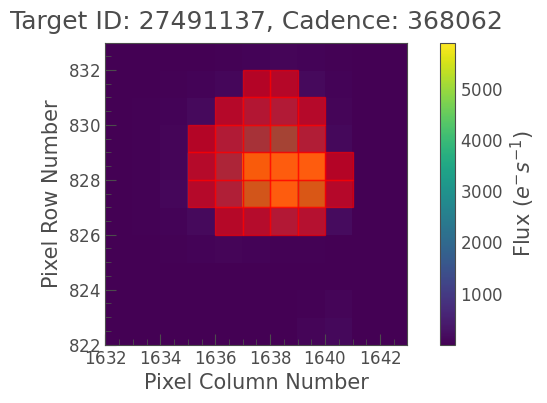

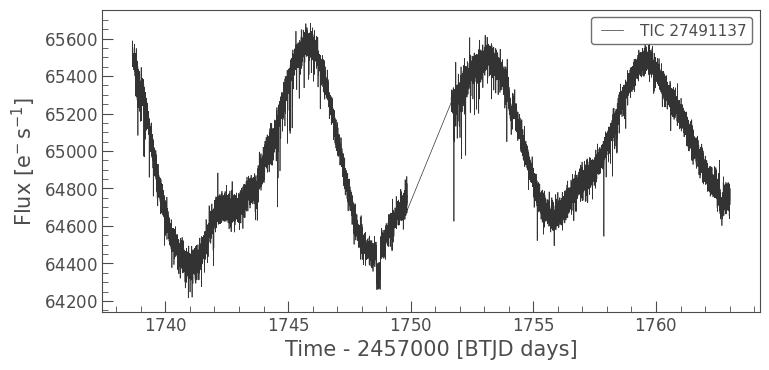

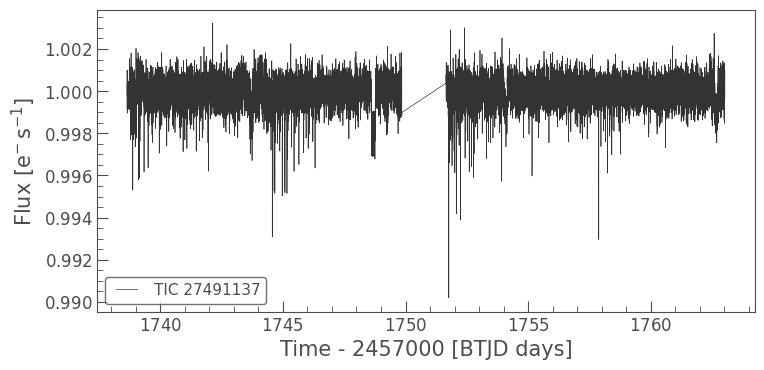

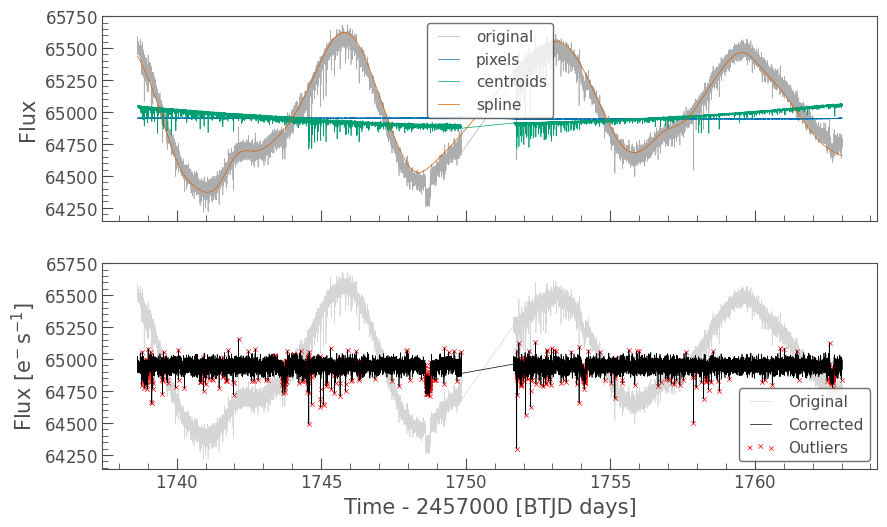

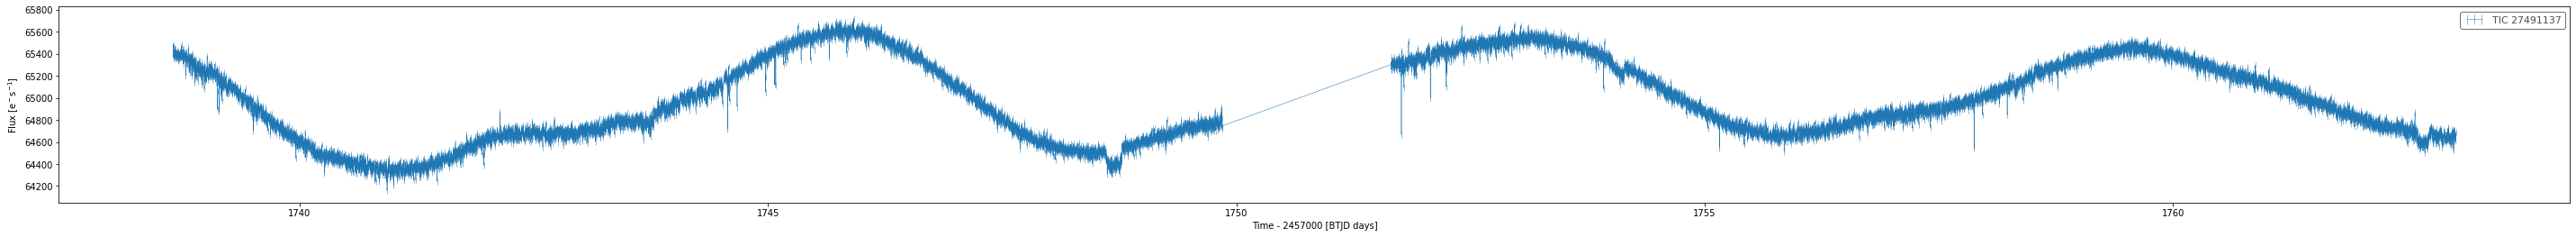

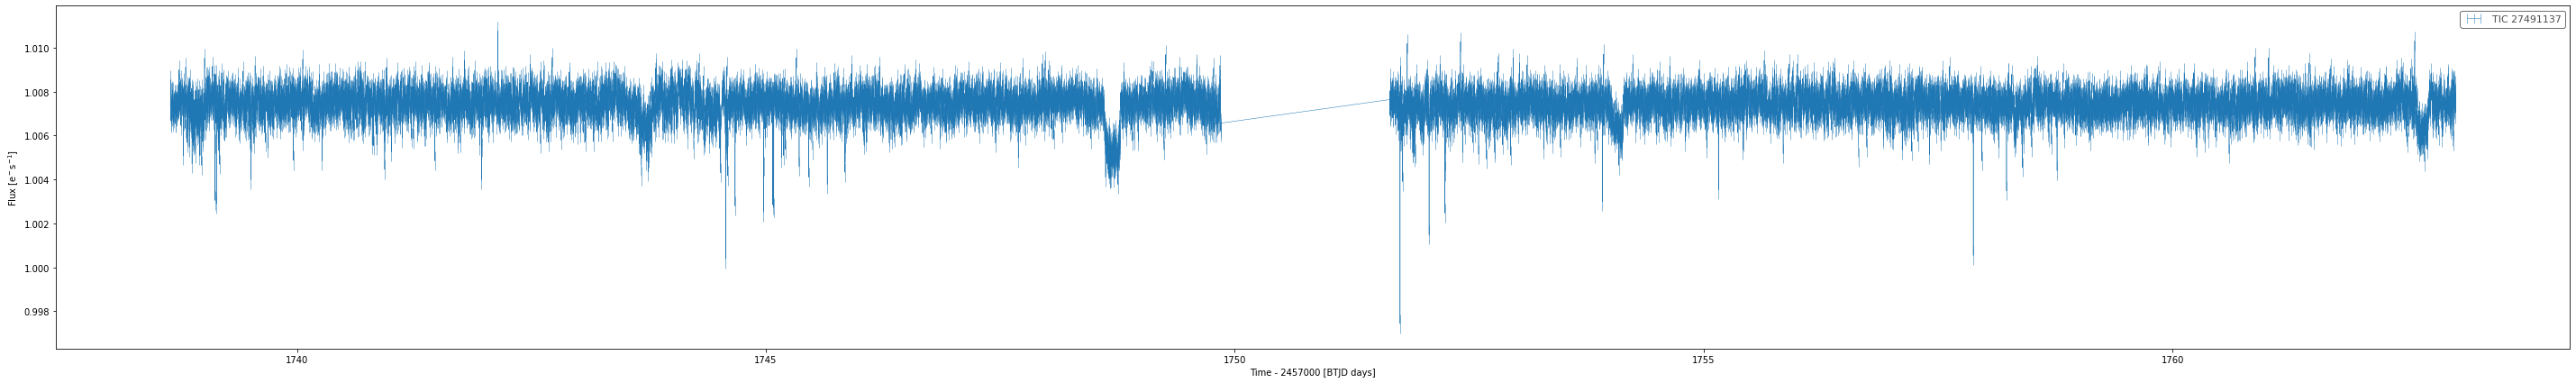

In [2]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

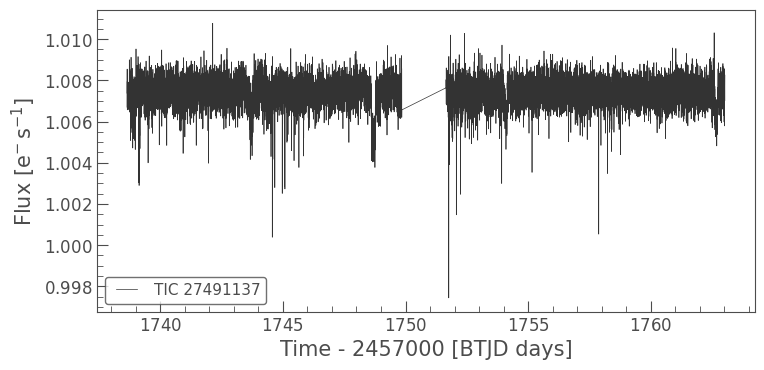

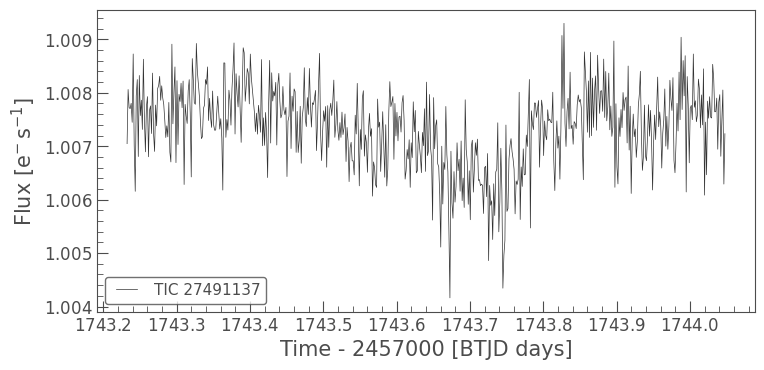

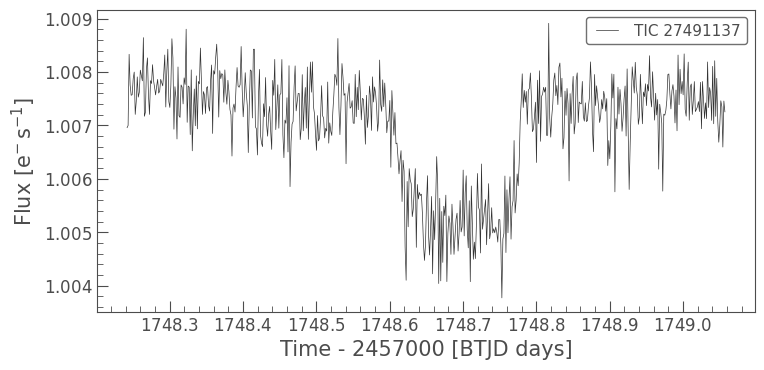

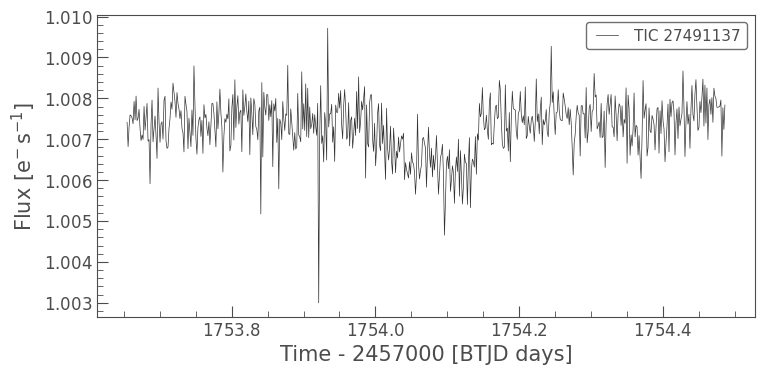

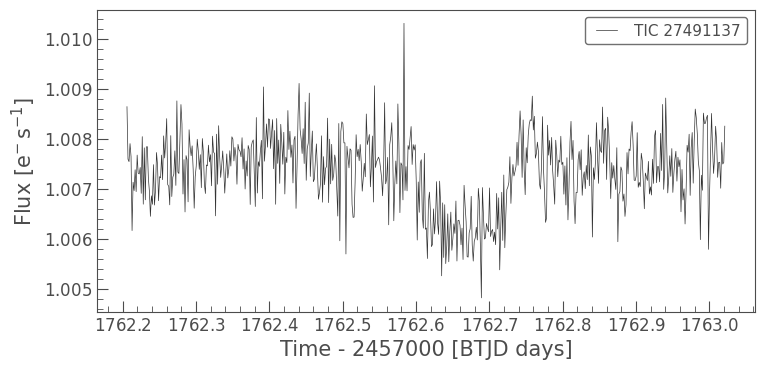

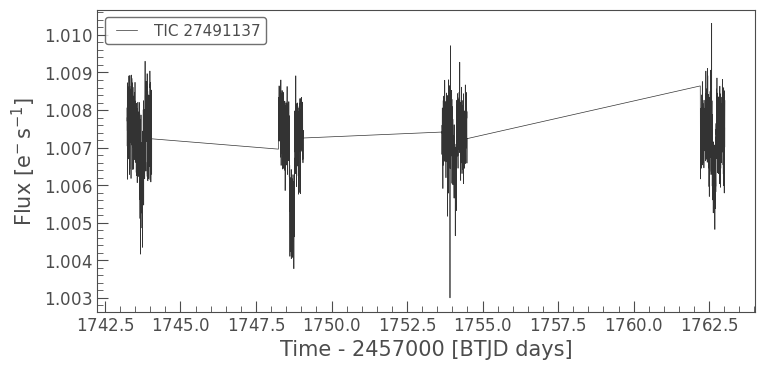

In [3]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()


#IMPORTANT THAT THE ARRAY SIZES FOR THE BELOW DIPS AREN'T CHANGED AS IT WILL AFFECT THE ACCURACY
#OF THE FULL MASKED LC AT THE BOTTOM OF THE CELL. ANY CHANGES IN INDIVIDUAL DIP ARRAY SIZE NEEDS TO BE 
#REFLECTED IN THE MASKING OF THE "AllDips" LC. 



#DIP 1
dip1 = clean_lc[3300:3888]
dip1.plot()

d1x = np.append( np.array( [], dtype="float64" ),dip1.time )
d1y = np.append( np.array( [], dtype="float64" ), dip1.flux - 1.0075 )
d1y_err = np.append( np.array( [], dtype="float64" ), dip1.flux_err )

#DIP 2
dip2 = clean_lc[6900:7488]
dip2.plot()

d2x = np.append( np.array( [], dtype="float64" ),dip2.time )
d2y = np.append( np.array( [], dtype="float64" ), dip2.flux - 1.0075 )
d2y_err = np.append( np.array( [], dtype="float64" ), dip2.flux_err )

#DIP 3
dip3 = clean_lc[9500:10100]
dip3.plot()

d3x = np.append( np.array( [], dtype="float64" ),dip3.time )
d3y = np.append( np.array( [], dtype="float64" ), dip3.flux - 1.0075 )
d3y_err = np.append( np.array( [], dtype="float64" ), dip3.flux_err )

#DIP 4
dip4 = clean_lc[15650:]
dip4.plot()

d4x = np.append( np.array( [], dtype="float64" ),dip4.time )
d4y = np.append( np.array( [], dtype="float64" ), dip4.flux - 1.0075 )
d4y_err = np.append( np.array( [], dtype="float64" ), dip4.flux_err )


#CREATING A MASKED LC SHOWING JUST THE TRANSITS ABOVE
mask1 = (clean_lc.time < 1738.64923721) | (clean_lc.time > 1743.23244862) 
m1lc = clean_lc[mask1]
mask2 = (m1lc.time < 1744.04770813) | (m1lc.time > 1748.24207156) 
m2lc =  m1lc[mask2]
mask3 = (m2lc.time < 1749.0573360) | (m2lc.time > 1753.65447995) 
m3lc = m2lc[mask3]
mask4 = (m3lc.time < 1754.48641353) | (m3lc.time > 1762.20580501) 
AllDips = m3lc[mask4]
AllDips.plot()

ADx = np.append( np.array( [], dtype="float64" ),AllDips.time )
ADy = np.append( np.array( [], dtype="float64" ), AllDips.flux - 1.0075 )
ADy_err = np.append( np.array( [], dtype="float64" ), AllDips.flux_err )

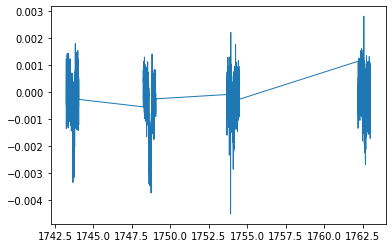

In [0]:
plt.plot(ADx, ADy, color="C0", lw=1)


In [0]:
dlcx = np.append( np.array( [], dtype="float64" ),clean_lc.time )
dlcy = np.append( np.array( [], dtype="float64" ), clean_lc.flux - 1.0075 )
dlcy_err = np.append( np.array( [], dtype="float64" ), clean_lc.flux_err )

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b4, b3, b2, b1, r4, r3, r2, r1, u, period4, period3, period2, period1, t04, t03, t02, t01, mean, radius_p4, radius_p3, radius_p2, radius_p1, cot4, cot3, cot2, cot1, m_star, radius_star, r_star]


/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 293139.8984384692 -> 371421.710140633


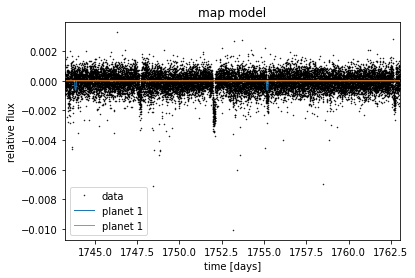

In [23]:
#@title Default title text
import exoplanet as xo
import pymc3 as pm

with pm.Model() as model:
    #defining star vars
    r_star = pm.Normal("r_star", mu=0.772148, sd= 0.0454673,testval= 0.78)
    radius_s = pm.Normal("radius_star", mu=0.772148, sd= 0.0454673,testval= 0.78)
    mass_s = pm.Normal("m_star", mu=0.87, sd=0.108032, testval= 0.87)

    t = np.linspace(1743.23244863,1763.021081332, 16238)
  

    #defining planet vars 
    t01 = pm.Normal("cot1", mu=1743.72, sd=0.01, testval= 1743.72)
    t02 = pm.Normal("cot2", mu=1748.69, sd=0.01, testval= 1748.69)
    t03 = pm.Normal("cot3", mu=1754.075, sd=0.01, testval= 1754.075)
    t04 = pm.Normal("cot4", mu=1762.67, sd=0.01, testval= 1762.67)
    #t0s = np.array([cot1, cot2, cot3, cot4])

    radius_p1 = pm.Uniform("radius_p1", lower=0.027, upper=0.033, testval=0.03, shape=4)
    radius_p2 = pm.Uniform("radius_p2", lower=0.02, upper=0.05, testval=0.04, shape=4)
    radius_p3 = pm.Uniform("radius_p3", lower=0.022, upper=0.042, testval=0.032, shape=4)
    radius_p4 = pm.Uniform("radius_p4", lower=0.014, upper=0.054, testval=0.034, shape=4)



    #P1 = pm.Uniform("period1", lower=7, upper=11, testval=10, shape=4)
    #P2 = pm.Uniform("period2", lower=7, upper=11, testval=10, shape=4)
    #P3 = pm.Uniform("period3", lower=7, upper=11, testval=10, shape=4)
    #P4 = pm.Uniform("period4", lower=7, upper=11, testval=10, shape=4)
    
   



    # The baseline flux
    mean = pm.Normal("mean", mu=0, sd=0.0001)

    # The time of a reference transit for each planet
    t01 = pm.Normal("t01", mu=t01, sd=0.01, shape=4)
    t02 = pm.Normal("t02", mu=t02, sd=0.01, shape=4)
    t03 = pm.Normal("t03", mu=t03, sd=0.01, shape=4)
    t04 = pm.Normal("t04", mu=t04, sd=0.01, shape=4)

    # The log period; also tracking the period itself
    period1 = pm.Uniform("period1", lower=0, upper=1000, testval=10, shape = 4)
    period2 = pm.Uniform("period2", lower=0, upper=1000, testval=10, shape = 4)
    period3 = pm.Uniform("period3", lower=0, upper=1000, testval=10, shape = 4)
    period4 = pm.Uniform("period4", lower=0, upper=1000, testval=10, shape = 4)
    #period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.525, 0.215]))

    #r is in units of R_star which is units of R_sun
    #r needs to encompass all possible radii for the 4 transits
    r1 = radius_p1 = pm.Uniform("r1", lower=0.027, upper=0.033, testval=0.03, shape=4)
    r2 = radius_p2 = pm.Uniform("r2", lower=0.02, upper=0.05, testval=0.04, shape=4)
    r3 = radius_p3 = pm.Uniform("r3", lower=0.022, upper=0.042, testval=0.032, shape=4)
    r4 = radius_p4 = pm.Uniform("r4", lower=0.014, upper=0.054, testval=0.034, shape=4)
  
    b1 = xo.distributions.ImpactParameter("b1", ror=r1/r_star, testval=0.1, shape=4)
    b2 = xo.distributions.ImpactParameter("b2", ror=r2/r_star, testval=0.1, shape=4)
    b3 = xo.distributions.ImpactParameter("b3", ror=r3/r_star, testval=0.1, shape=4)
    b4 = xo.distributions.ImpactParameter("b4", ror=r4/r_star, testval=0.1, shape=4)

    
    #need to declare the stellar parameters in either orbit or light_curves

    # Set up a Keplerian orbit for the planets
    orbit1 = xo.orbits.KeplerianOrbit(period=period1, t0=t01, b=b1)
    orbit2 = xo.orbits.KeplerianOrbit(period=period2, t0=t02, b=b2)
    orbit3 = xo.orbits.KeplerianOrbit(period=period3, t0=t03, b=b3)
    orbit4 = xo.orbits.KeplerianOrbit(period=period4, t0=t04, b=b4)

    # Compute the model light curve using starry
    light_curves1 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit1, r=r1, t=t)
    light_curve1 = pm.math.sum(light_curves1, axis=-1) + mean

    light_curves2 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit2, r=r2, t=t)
    light_curve2 = pm.math.sum(light_curves2, axis=-1) + mean

    light_curves3 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit3, r=r3, t=t)
    light_curve3 = pm.math.sum(light_curves3, axis=-1) + mean

    light_curves4 = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit4, r=r4, t=t)
    light_curve4 = pm.math.sum(light_curves4, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves1", light_curves1)
    pm.Deterministic("light_curves2", light_curves2)
    pm.Deterministic("light_curves3", light_curves3)
    pm.Deterministic("light_curves4", light_curves4)

    # In this line, we simulate the dataset that we will fit
    y = dlcy
    
    # The likelihood function assuming known Gaussian uncertainty- 
    #Likelihood function is a function that represents the distribution from an actual test sample
    pm.Normal("obs1", mu=light_curve1, sd=dlcy_err, observed=y)
    pm.Normal("obs2", mu=light_curve2, sd=dlcy_err, observed=y)
    pm.Normal("obs3", mu=light_curve3, sd=dlcy_err, observed=y)
    pm.Normal("obs4", mu=light_curve4, sd=dlcy_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated dataset
    # Posterior distribution is usually given as Prior*Likelihood
    map_soln = xo.optimize(start=model.test_point)


plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves1"][:, i], lw=1, label="planet {0}".format(1)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [13]:
len.ADy

AttributeError: ignored

In [14]:
len(ADy)

2363

In [16]:
len(ADy_err)

2363